### Settings


tensorflow version에 따라 `tf.keras.layers.GRU`의 반환 방식이 달라 version 확인 및 downgrade 진행

In [1]:
import tensorflow as tf
print(tf.__version__)

2.12.0


version이 2.12.0 이하라면 다음 코드는 생략하셔도 괜찮습니다.

In [2]:
pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 90.0 MB/s eta 0:00:00
   ━━━━━━━━━━

## **예습 코드**

[실습명: 어텐션을 사용한 인공 신경망 기계 번역]
- http://www.manythings.org/anki/ 에서 제공한 언어 데이터셋을 사용.

- 이 노트북은 스페인어를 영어로 변역하기 위해 시퀀스-투-시퀀스 (seq2seq) 모델을 훈련시킵니다. 또한 이 노트북은 시퀀스-투-시퀀스 모델의 사전적인 지식을 요구하는 심화된 예제입니다.

- 이 노트북에서 신경망 기계 번역 모델을 훈련하면 *"¿todavia estan en casa?"*와 같은 스페인 문장을 입력했을 때 *"are you still at home?"*처럼 영어로 번역된 문장을 얻을 수 있을 것입니다

- 아래의 플롯은 모델을 훈련하는 동안에 입력 문장의 각 단어가 갖고 있는 모델 어텐션을 시각화하여 보여준 것입니다:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">


In [2]:
import tensorflow as tf

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

### 데이터셋 준비

http://www.manythings.org/anki/ 에서 제공한 언어 데이터셋을 사용할 것입니다. 이 데이터셋은 언어 번역의 쌍이 다음과 같은 형식으로 포함되어 있습니다:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

다양한 언어가 이용가능하지만 이 예제에서는 영어-스페인 데이터셋을 사용할 것입니다. 편의를 위해서 이 데이터셋의 복사본을 Google Cloud에서 호스팅 했지만 직접 다운로드해야 합니다. 데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행합니다.

1. 각 문장에 *start*와 *end* 토큰을 추가합니다.
2. 특정 문자를 제거함으로써 문장을 정리합니다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [3]:
# 파일을 다운로드합니다.
path_to_zip = tf.keras.utils.get_file(
    'spa-eng.zip', origin='http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/spa-eng/spa.txt"

2638744/2638744 [==============================] - 0s 0us/step


In [4]:
# 유니코드 파일을 아스키 코드 파일로 변환합니다.
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


# 전처리 코드
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip()) # 유니코드 파일을 아스키 코드 파일로 변환하여 w 반환

  # 단어와 단어 뒤에 오는 구두점(.)사이에 공백을 생성합니다.
  # 예시: "he is a boy." => "he is a boy ."
  # 참고:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w) # 모든 문장 부호를 그룹으로 ()을 사용하여 묶고, 그 그룹 앞뒤에 공백을 넣음
  # 이 과정은 문장 부호도 하나의 토큰으로 인식하게 만들어 더 잘 학습되기 만들어줌.
  w = re.sub(r'[" "]+', " ", w) #위 과정에서 혹시나 하나 이상의여러 공백이 생긴 경우에는 하나의 공백으로 변경해줌.

  # (a-z, A-Z, ".", "?", "!", ",")을 제외한 모든 것을 공백으로 대체합니다.
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # 모델이 예측을 시작하거나 중단할 때를 알게 하기 위해서
  # 문장에 start와 end 토큰을 추가합니다.
  w = '<start> ' + w + ' <end>'
  return w

In [5]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8')) # utf-8 : 바이트로 처리하여 ¿가 16진수 바이트 값으로 표현되어 나옴

<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [6]:
# 1. 문장에 있는 억양을 제거합니다.
# 2. 불필요한 문자를 제거하여 문장을 정리합니다.
# 3. 다음과 같은 형식으로 문장의 쌍을 반환합니다: [영어, 스페인어]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n') # 위에서 보았듯 ¿를 처리하기 위해 UTF-8로 인코딩하여 엶. 문자열 앞뒤의 불필요 공백이나 줄바꿈 제거, \n으로 스플릿하여 리스트화

  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]] # line리스트에서 함수가 받은 num_example 만큼만 가져와 l에 대해 처리
  # 우리의 파일은 영어문장\t스페인어문장 구조로 한 열식 들어가 있기에 앞선 lines 과정에서 l이 영어문장\t스페인어문장 이런 형태를 띄고 있음.
  # 이런 l을 \t로 나누어서 영어문장, 스페인어 문장으로 각각 쪼개어 주고 이런 w에 대해 전처리를 진행
  # 이에 word_pairs는 [ [영어문장, 스페인어문장], [영어문장, 스페인어문장] , ....] 이런 구조의 리스트가 됨.

  return zip(*word_pairs) # *word_pairs : word_paris의 리스트의 각 요소를 개별 인자로 풀어줌 -> 즉 zip([영1, 스1], [영2, 스2], ...) 와 같이 호출
  # zip 함수는 같은 인덱스에 있는 요소들을 튜플로 묶어줌. 이에 [(영1, 영2, ...), (스1, 스2, ...)]이 되고. 이런 튜플 두개를 반환하게 됨

In [7]:
en, sp = create_dataset(path_to_file, None) # 위에서 설명한 것 처럼 2개의 튜플을 반환하게 되어 이를 각각 en, sp로 받게됨
print(en[-1])
print(sp[-1])

<start> if you want to sound like a native speaker , you must be willing to practice saying the same sentence over and over in the same way that banjo players practice the same phrase over and over until they can play it correctly and at the desired tempo . <end>
<start> si quieres sonar como un hablante nativo , debes estar dispuesto a practicar diciendo la misma frase una y otra vez de la misma manera en que un musico de banjo practica el mismo fraseo una y otra vez hasta que lo puedan tocar correctamente y en el tiempo esperado . <end>


In [8]:
def tokenize(lang): # 토큰화
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
      filters='') # lang_tokenizer에 tf.keras의 클래스를 넣어
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                         padding='post')

  return tensor, lang_tokenizer # 토크나이저로 만들어진 텐서, 토크나이저 인스턴스

In [10]:
# 통합 데이터 로드 함수 (앞선 과정을 모두 통합)
def load_dataset(path, num_examples=None):
  # 전처리된 타겟 문장과 입력 문장 쌍을 생성합니다.
  targ_lang, inp_lang = create_dataset(path, num_examples) # 타겟 랭, 인풋 랭을 create_dataset으로 불러옴.(전처리는 완료)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang) #인풋 랭 토큰화 -> 인스턴스도 반환
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang) #타겟 랭 토큰화

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

###  더 빠른 실행을 위해 데이터셋의 크기 제한하기(선택)

10만개 이상의 문장이 있는 완전한 데이터셋을 훈련하는 것은 오랜 시간이 걸립니다. 훈련 속도를 높이기 위해서 데이터셋의 크기를 3만개의 문장으로 제한합니다. (물론, 번역의 질은 데이터가 적어질수록 저하됩니다):

In [11]:
# 언어 데이터셋을 아래의 크기로 제한하여 훈련과 검증을 수행합니다.
num_examples = 30000 #크기 제한
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
# 각각 인풋, 타겟 텐서 집합, inp_lang, targ_lang은 토크나이저의 인스턴스 (= 사실상의 객체)
# 타겟 텐서와 입력 텐서의 최대 길이를 계산합니다.
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1] # 추후 패딩을 위해 텐서의 최대 길이를 미리 얻어둠
# shape[0]: 문자 행의 수 여기서는 30000, shape[1] : 텐서의 최대 길이 (토큰화 과정에서 가장 긴 문장을 기준으로 패딩이 되어 텐서의 최대 길이만큼 패딩되어 출력되어있음)

In [12]:
# 훈련 집합과 검증 집합을 80대 20으로 분리합니다.
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# 훈련 집합과 검증 집합의 데이터 크기를 출력합니다.
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

24000 24000 6000 6000


In [14]:
def convert(lang, tensor):#토크나이저 객체, 하나의 문장에 대한 tensor를 입력 받음
  for t in tensor: # 하나의 문장에 대한 텐서 중에 하나씩
    if t!=0: # 패딩이 아닌 것에 대해서
      print ("%d ----> %s" % (t, lang.index_word[t])) # 텐서 ---> 문자열 구조로 표현
      # 텐서의 각 값, 텐서의 각 값(숫자 인덱스)를 실제 단어로 변환 lang.index_word[t]는 토크나이저가 가지고 있는 딕셔너리


In [15]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0]) #토크나이저 객체, 하나의 문장에 대한 tensor를 입력 받음
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> no
81 ----> voy
10 ----> a
4445 ----> molestarte
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
4 ----> i
100 ----> won
12 ----> t
835 ----> bother
6 ----> you
3 ----> .
2 ----> <end>


### tf.data 데이터셋 생성하기

In [16]:
# 하이퍼 파라미터 정의
BUFFER_SIZE = len(input_tensor_train) # 텐서 집합의 길이 만큼 버퍼 사이즈 정의 -> suffle 메소드에서 전체 데이터셋을 완전히 섞는 효과를 가져옴.
BATCH_SIZE = 64 # 모델을 한번 훈련시킬 때마다 사용할 데이터의 수
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE # 하나의 에포크에 몇개의 스텝이 필요한지.
embedding_dim = 256
units = 1024 # 뉴런, 유닛의 갯수
vocab_inp_size = len(inp_lang.word_index)+1 # 보카블러리 사이즈는 토큰화과정에서 얻은 tokenizer 인스턴스의 word_index를 이용하여 텐서의 크기를 바탕으로 제작
# 0번 인덱스는 패딩을 위해 사용하기에 단어-인덱스 사전보다 하나 더 늘려줌
vocab_tar_size = len(targ_lang.word_index)+1

# tf.data.Dataset API를 사용하여 훈련 데이터를 효과적으로 모델에 공급
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
# tf.data.Dataset.from_tensor_slices(...): input_tensor_train과 target_tensor_train을 합쳐서 데이터셋을 만듭니다.
#이 함수는 텐서의 첫 번째 차원을 따라 데이터를 슬라이스하여, (입력 문장 1, 타겟 문장 1), (입력 문장 2, 타겟 문장 2) 와 같은 쌍으로 데이터셋을 구성합니다.
# sfuffle로 섞음
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # 데이터셋을 제작 BATCH-SIZE 만큼 배치로 묶어줌. 모든 배치 크기를 동일하게 유지하기 위해 drop_remainder를 켜둠

In [17]:
example_input_batch, example_target_batch = next(iter(dataset)) # 64개씩 묶인 데이터 배치의 모음에서 iter로 순서대로 꺼내어서 가장 앞부터 사용해서 batch로 만듦
example_input_batch.shape, example_target_batch.shape # 인풋 은 최대 16개의 토큰으로, 타겟은 최대 11개의 토큰으로 이루어짐

(TensorShape([64, 16]), TensorShape([64, 11]))

## 인코더 모델과 디코더 모델 쓰기

어텐션(attention)을 가진 인코더-디코더 모델을 수행합니다. 어텐션(attention)은 TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt)에서 읽을 수 있습니다. 이 예제는 더 최신의 API 집합을 사용합니다. 이 노트북은 seq2seq 튜토리얼로부터 [어텐션 방정식](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism)을 수행합니다. 아래의 다이어그램은 각각의 입력 단어가 어텐션 메커니즘에 의해 가중치가 할당된 모습입니다. 이러한 어텐션 메커니즘은 디코더가 문장에서 다음 단어를 예측하기 위해 사용됩니다. 아래의 그림과 공식은 [Luong's paper](https://arxiv.org/abs/1508.04025v5)에서 나온 어텐션 메커니즘의 예시입니다.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

입력은 *(batch_size, max_length, hidden_size)*의 형태로 이루어진 인코더 결과와 *(batch_size, hidden_size)*쌍으로 이루어진 인코더 은닉 상태(hidden state)를 제공하는 인코더 모델을 통해 입력됩니다.

아래의 공식은 위에서 사용한 방정식을 나타낸 것이다:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

이 튜토리얼은 인코더를 위해 [Bahdanau 어텐션](https://arxiv.org/pdf/1409.0473.pdf)을 사용합니다. 단순화된 형태로 쓰기 전에 표기법을 아래와 같이 정의합니다:

* FC = 완전 연결(Dense)층
* EO = 인코더 결과
* H = 은닉 상태(hidden state)
* X = 디코더에 대한 입력

그리고 다음은 슈도코드입니다:

* `스코어(score)는 FC(tanh(FC(EO) + FC(H)))`로 계산합니다.
* `어텐션 가중치는 softmax(score, axis = 1)`로 계산합니다. 기본적으로 소프트맥스는 마지막 축을 적용하지만 스코어(score)의 형태가 *(batch_size, max_length, hidden_size)*이기 때문에 *첫번째 축*을 적용합니다. `Max_length`은 입력의 길이입니다. 각각의 입력에 가중치를 할당하려고 시도하기 때문에 소프트맥스는 그 축을 적용할 수 있습니다.
* `컨텍스트 벡터(context vector)는 sum(어텐션 가중치 * EO, axis = 1)`로 계산합니다. 위와 같은 이유로 첫번째 축을 선택합니다.
* `임베딩 결과(embedding output)`는 디코더 X에 대한 입력이 임베딩층을 통과한 결과입니다.
* `병합된 벡터(merged vector)는 concat(임베딩 결과, 컨텍스트 백터(context vector))`와 같습니다.
* 그런 다음 병합된 벡터는 GRU에 주어집니다.

매 단계마다 모든 벡터의 형태는 코드내 주석에 명시되어 있습니다:

In [18]:
class Encoder(tf.keras.Model): # 인코더
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # 임베딩 클래스
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') # enc_units 만큼의 뉴런을 가진 GRU 클래스

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state = self.gru(x, initial_state = hidden)
    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [19]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE) # 인풋 언어에 대한 인코더 인스턴스 생성 하이퍼 파리미터를 넣음

# 샘플 입력
sample_hidden = encoder.initialize_hidden_state() # Encoder의 메소드 사용하여 sample hidden 은닉층 0으로 초기화
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden) # 인풋 언어에 대한 배치된 데이터와 sample_hidden을 넣어 sample_output과 sample hidden을 출력
# 즉 우리가 만든 encoder가 잘 만들어졌는지 눈으로 확인 -> 위에서 정의한 배치 사이즈, 각 배치에 들어간 데이터의 길이, 유닛 수, 은닉층 모두 잘 만들어짐.
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

Encoder output shape: (batch size, sequence length, units) (64, 16, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)


어텐션의 역할

어텐션 메커니즘은 디코더(번역 문장을 생성하는 부분)가 번역할 단어를 예측하는 매 순간, 인코더가 만든 입력 문장의 어떤 단어에 더 집중해야하는지를 알려주는 역할을함.


In [20]:

class BahdanauAttention(tf.keras.layers.Layer): # 앞선 마크다운에서 적힌 Bahdanau Attention 클래스 정의
  def __init__(self, units): # 파이토치 형태의 초기화
    super(BahdanauAttention, self).__init__() # 초기화
    #어텐션 스코어를 계산하는데 사용될 3개의 완전 연결(Dense) 레이어
    self.W1 = tf.keras.layers.Dense(units) # GRU 수 만큼
    self.W2 = tf.keras.layers.Dense(units) # GRU 수 만큼
    self.V = tf.keras.layers.Dense(1) # 1개
    # 이 레이어들이 학습 과정에서 최적의 가중치를 찾아가게 됨.

  def call(self, query, values):
    # query: 디코더의 이전 은닉 상태 (batch_size, units)
    # values: 인코더의 모든 출력 (batch_size, max_length, units)

    ''' Score 계산을 위한 준비 과정 '''

    # 쿼리 은닉 상태(query hidden state)는 (batch_size, hidden size)쌍으로 이루어져 있습니다.
    # query_with_time_axis은 (batch_size, 1, hidden size)쌍으로 이루어져 있습니다.
    # values는 (batch_size, max_len, hidden size)쌍으로 이루어져 있습니다.

    # 스코어(score)계산을 위해 덧셈을 수행하고자 시간 축을 확장하여 아래의 과정을 수행합니다.
    query_with_time_axis = tf.expand_dims(query, 1) # query의 차원을 늘려서 Values(인코더의 모든 출력)과 더할 수 있게 만듦

    '''attention score 계산 과정'''

    # self.V에 적용하기 전에 텐서는 (batch_size, max_length, units)쌍으로 이루어져 있습니다.
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values))) # 디코더의 이전 정보와 인코더의 모든 단어 정보를 결합하고 비선형함수(tanh)를 통과시키고 이후에 self.V를 통과하여 스코어를 계산
    # score는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
    # score를 self.V에 적용하기 때문에 마지막 축에 1을 얻습니다. <- V 층의 유닛 수는 1이기에 V layer 통과하여 score와 동일한 shape을 가지게 됨.

    '''attention weights 계산'''
    # attention_weights는 (batch_size, max_length, 1)쌍으로 이루어져 있습니다.
    attention_weights = tf.nn.softmax(score, axis=1) # 위에서 계산된 score를 softmax(총합이 1이 되도록 정규화)를 통과하여 사실상 확률값으로 변경

    '''Context vector 생성'''
    # 덧셈이후 컨텍스트 벡터(context_vector)는 (batch_size, hidden_size)쌍으로 이루어져 있습니다.
    context_vector = attention_weights * values # 어텐션 weigths(확률값)에 인코더의 모든 단어 정보를 곱하여 context vector 계산 (중요한 단어의 정보는 더 크게, 덜 중요한 것은 더 작게)
    context_vector = tf.reduce_sum(context_vector, axis=1) #가중치가 적용된 모든 단어의 정보를 하나로 합쳐서 context vector 계산
    # reduce_sum 이후 현재 시점에서 번역에 필요한 입력 문장의 핵심 정보를 압축한 결과물

    return context_vector, attention_weights
    # context_vector: 디코더가 다음 단어를 예측하는 데 사용할 압축된 정보입니다.
    # attention_weights: 각 단어에 얼마나 집중했는지를 나타내는 가중치입니다. 나중에 이 값을 시각화하여 모델이 어떻게 번역을 수행했는지 분석할 수 있습니다.

In [21]:
attention_layer = BahdanauAttention(10) # 위에서 정의한 클래스로 인스턴스 attention_layer 생성
attention_result, attention_weights = attention_layer(sample_hidden, sample_output) # 어텐션 레이어에 sample을 넣어 잘 만들어졌나 확인

print("Attention result shape: (batch size, units) {}".format(attention_result.shape)) # 64개 문장의 배치에 1024개의 뉴런으로 만들어진 attention 결과 (컨텍스트 벡터)
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape)) # 어텐션 가중치 : 64개 문장에 각 문장은 16 길이에 1크기

Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 16, 1)


디코더

디코더의 역할은 인코더가 압축한 문맥 정보(context vector)를 받아서, 번역된 문장을 한 단어씩 순서대로 생성하는 것입니다

In [22]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim) # 타겟 언어의 단어를 임베딩 벡터로 변환하는 레이어
    self.gru = tf.keras.layers.GRU(self.dec_units, # 디코더 뉴런 수
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform') #GRU를 사용
    self.fc = tf.keras.layers.Dense(vocab_size) #GRU의 출력을 받아 타겟 언어의 전체 단어 사전의 크기로 벡터를 변환하는 완전 연결(dense) 레이어

    # 어텐션을 사용합니다.
    self.attention = BahdanauAttention(self.dec_units) # 어텐션 레이어, 인코더의 출력 중에 어떤 부분에 집중해야할 지를 결정

  def call(self, x, hidden, enc_output): # 번역 단어 생성 과정 : 한 타임스텝(한 단어)을 예측하는 과정임.
    # x: 현재 타임스텝의 입력 단어 (처음에는 <start> 토큰)
    # hidden: 디코더의 이전 타임스텝의 은닉 상태(hidden state)
    # enc_output: 인코더의 전체 출력 (모든 입력 단어에 대한 정보)
    # enc_output는 (batch_size, max_length, hidden_size)쌍으로 이루어져 있습니다.

    '''어텐션 계산 과정'''
    context_vector, attention_weights = self.attention(hidden, enc_output) #디코더의 현재 상태(hidden)과 인코더 전체 정보(enc_output)를 넣어서
    # 현재 시점에서 어떤 입력 단어에 집중해야할 지를 계산
    '''입력 단어 임베딩'''
    # 임베딩층을 통과한 후 x는 (batch_size, 1, embedding_dim)쌍으로 이루어져 있습니다.
    x = self.embedding(x) # 입력 단어(숫자 인덱스)를 임베딩 레이어를 통과시켜 밀집 벡터로 만듦
    '''컨텍스트 벡터와 임베딩 결합'''
    # 컨텍스트 벡터와 임베딩 결과를 결합한 이후 x의 형태는 (batch_size, 1, embedding_dim + hidden_size)쌍으로 이루어져 있습니다.
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1) #컨텍스트 벡터를 확장시켜서 x와 결합
    '''GRU 레이어 통과'''
    # 위에서 결합된 벡터를 GRU에 전달합니다.
    output, state = self.gru(x) # 현재 타임 스텝의 출력(output), 다음 타임스텝에 넘겨줄 새로운 은닉상태(state)를 계산
    # state는 다음 call이 호출될때 hidden으로 인풋됨.
    '''최종 예측'''

    # output은 (batch_size * 1, hidden_size)쌍으로 이루어져 있습니다.
    output = tf.reshape(output, (-1, output.shape[2])) # GRU의 출력을 2D 텐서로 변환

    # output은 (batch_size, vocab)쌍으로 이루어져 있습니다.
    x = self.fc(output) # 완전 연결 fc를 통과시켜 타겟 언어의 단어 사전의 단어 개수만큼의 크기를 갖는 벡터를 제작 -> 이 벡터에서 가장 높은 값을 가지는 인덱스가 바로 모델이 예측한 다음 단어임

    return x, state, attention_weights

In [23]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape)) # 디코더 잘 만들어져 있나 확인

Decoder output shape: (batch_size, vocab size) (64, 4935)


## 최적화 함수와 손실 함수 정의하기

In [24]:
optimizer = tf.keras.optimizers.Adam() # 최적화함수 loss 줄여나가는 방법 정의 인데  adam은 학습률을 동적으로 조절해가며 안정적으로 최적의 가중치를 찾아감
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') # 손실함수 정의 : 다중 분류 문제에 사용되는 손실함수를 사용(단어 사전에서 단어 하나를 맞추는 것이니)
    # from_logits=True : 모델의 최종 출력이 소프트맥스를 거치지 않은 원시값(logit)이므로 손실함수 내부에서 softmaㅌ적용
    # reduction='none' : 손실 계산할때 데이터 포인트(각 단어)에 대한 손실 값을 개별적으로 반환,(패딩을 제외한 손실만 계산하고자함)

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # 실제 정답 real에서 0인 부분에 True로 표시 -> logical_not으로 이를 논리 NOT 연산하여 마스킹
  loss_ = loss_object(real, pred) #실제와 예측간의 손실을 loss object으로 계산 (아직까지 패딩을 포함한 모든 부분의 손실이 계산이 된 것)

  mask = tf.cast(mask, dtype=loss_.dtype) # 위에서 정의한 mask에서 True, False를 loss_의 데이터 타입으로 변환함. (True는 1.0으로, False는 0.0으로 바뀜)
  loss_ *= mask # 위의 마스크를 이용해 위에서 구한 loss object의 결과물에 곱하면 패딩을 제외한 부분의 로스만 남게 됨.

  return tf.reduce_mean(loss_) # 텐서의 평균을 계산하여 최종 배치 손실을 반환

## 체크포인트 (객체 기반 저장)

In [25]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## 언어 모델 훈련하기

1. *인코더 결과*와 *인코더 은닉 상태(hidden state)*를 반환하는 *인코더*를 통해서 *입력*을 전달합니다.
2. 인코더 결과, 인코더 은닉 상태(hidden state), 디코더 입력 (*start 토큰*)을 디코더에 전달합니다.
3. 전달 받은 값을 통해 디코더는 *예측 값*과 *디코더 은닉 상태(hidden state)*를 반환합니다.
4. 그 다음에 디코더 은닉 상태(hidden state)가 다시 모델에 전달되고 예측 값을 사용하여 손실을 계산합니다.
5. 디코더에 대한 다음 입력을 결정하기 위해서 *교사 강요(teacher forcing)*를 사용합니다.
6. *교사 강요(teacher forcing)*는 *타겟 단어*가 디코더에 *다음 입력*으로 전달하기 위한 기술입니다.
7. 마지막 단계는 그레디언트(gradients)를 계산하여 이를 옵티마이저(optimizer)와 역전파(backpropagate)에 적용합니다.

In [26]:
@tf.function
# 이 표시는 파이썬 함수를 텐서플로우의 고성능 그래프(Graph)로 컴파일하라는 지시어입니다. 파이썬 코드를 그대로 실행하는 것보다 훨씬 빠른 속도로 연산을 수행할 수 있게 해주는 최적화 기능입니다.
def train_step(inp, targ, enc_hidden): # 딥러닝 훈련의 한 사이클을 정의하는 함수
  loss = 0

  with tf.GradientTape() as tape: # 자동 미분을 위한 테이프 with 블록 안에서 일어난 모든 연산을 테이프에 기록하여 이 기록을 되감아 손실에 대한 각 가중치의 기울기를 자동으로 계산
    enc_output, enc_hidden = encoder(inp, enc_hidden) # 인코더 실행 (입력 문장, 초기 은닉상태)를 인코더에 통과시켜 인코더 출력과 최종 은닉상태를 얻음

    dec_hidden = enc_hidden # 디코더 초기화 : 인코더의 최종 은닉상태를 디코더의 첫번째 은닉상태로 계승 즉 입력 문장의 문맥을 디코더로 전달

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1) # 디코더 첫 입력 준비 : 번역을 시작하기 위해 배치내 모든 문장에 대해 <start> 토큰을 입력으로 주고자 복제하여 dec_input을 만듦

    # 교사 강요(teacher forcing) - 다음 입력으로 타겟을 피딩(feeding)합니다.
    for t in range(1, targ.shape[1]): # 타겟 문장의 길이 만큼 반복하면서 다음 단어를 예측 이때 초기에 <start>토큰을 사용하였기에 1부터 시작하여 순회
      # enc_output를 디코더에 전달합니다.
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output) # 디코더 인풋, 디코더 은닉상태, 인코더 결과물을 디코더에 넣음
      # 위에서 정의한 디코더를 따라서 어텐션레이어에 의해서 인코더의 문맥을 담은 컨텍스트 벡터를 만들고 이 벡터와 디코더 인풋을 결합시켜 GRU에 의해 예측하고 은닉 상태를 출력함

      loss += loss_function(targ[:, t], predictions) # 실제 정답 사이의 손실을 누적시킴 (단어별로)

      # 교사 강요(teacher forcing)를 사용합니다.
      dec_input = tf.expand_dims(targ[:, t], 1) # Teaching force(교사 강요)의 핵심 코드로 모델이 방금 예측한 입력으로 dec_input을 쓰는 것이 아닌 정답지(실제 타겟)의 단어를 입력으로 넣어줌
      # 훈련 초기에 엉터리 출력이 지속적으로 나쁜 영향을 미치는 것을 막는데 효과적임

  batch_loss = (loss / int(targ.shape[1])) # 단어별(좀더 엄밀하게는 토큰별)로 누적된 손실을 타겟 문장의 전체 길이로 나누어 각 단어별 평균 손실을 구함.

  variables = encoder.trainable_variables + decoder.trainable_variables # 인코더 디코더의 variables를 모음

  gradients = tape.gradient(loss, variables) # 누적된 loss에 대한 각 가중치들의 기울기들을 구함

  optimizer.apply_gradients(zip(gradients, variables)) # 계산된 기울기를 Adam(optimizer)에 전달하여 가중치를 업데이트하면 손실이 줄어든다는 정보에 따라 가중치를 업데이트함 역전파시킴.

  return batch_loss

In [27]:
EPOCHS = 10 # epoch : 전체 훈련 데이터셋을 처음부터 끝까지 전부 한번씩 사용하는 훈련의 횟수

for epoch in range(EPOCHS): # 10번 훈련하겠다
  start = time.time() # 한 에포크당 걸린 시간 측정 (지금 대충 1400초씩 약 23분씩 걸리고 있음)

  enc_hidden = encoder.initialize_hidden_state() # 매 에포크가 시작할때마다 인코더의 은닉상태를 초기화 시킴
  total_loss = 0 # 이번 에포크의 총 손실을 기록할 total_loss의 변수를 0으로 초기화

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)): # steps_per_epoch (전체 배치의 수)만큼 가져와서 배치의 순서와 배치 데이터를 제공
    batch_loss = train_step(inp, targ, enc_hidden) # 배치 단위로 실제 훈련을 진행하는데 각 배치를 train_step에 넣어 한 스텝을 진행하고 그 결과로 나온 batch_loss를 받아
    total_loss += batch_loss # total_loss에 누적시킴

    if batch % 100 == 0: # 100개의 배치를 훈련할때 마다 한번씩 현재 진행상황을 출력
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # 에포크가 2번 실행될때마다 모델 저장 (체크포인트)
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix) # 현재까지 훈련된 모델의 가중치를 파일로 저장
  # 하나의 에포크가 모두 끝나면 이번 에포크의 평균 손실을 출력시킴
  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.4816
Epoch 1 Batch 100 Loss 2.2180
Epoch 1 Batch 200 Loss 1.9283
Epoch 1 Batch 300 Loss 1.7933
Epoch 1 Loss 2.0493
Time taken for 1 epoch 1370.0204212665558 sec

Epoch 2 Batch 0 Loss 1.6031
Epoch 2 Batch 100 Loss 1.4750
Epoch 2 Batch 200 Loss 1.4081
Epoch 2 Batch 300 Loss 1.2852
Epoch 2 Loss 1.4508
Time taken for 1 epoch 1356.53946185112 sec

Epoch 3 Batch 0 Loss 1.1617
Epoch 3 Batch 100 Loss 1.1149
Epoch 3 Batch 200 Loss 1.1180
Epoch 3 Batch 300 Loss 0.9165
Epoch 3 Loss 1.0286
Time taken for 1 epoch 1309.2511625289917 sec

Epoch 4 Batch 0 Loss 0.8085
Epoch 4 Batch 100 Loss 0.7388
Epoch 4 Batch 200 Loss 0.7254
Epoch 4 Batch 300 Loss 0.7066
Epoch 4 Loss 0.7151
Time taken for 1 epoch 1480.19304561615 sec

Epoch 5 Batch 0 Loss 0.5203
Epoch 5 Batch 100 Loss 0.4529
Epoch 5 Batch 200 Loss 0.5547
Epoch 5 Batch 300 Loss 0.5136
Epoch 5 Loss 0.5009
Time taken for 1 epoch 1464.894416809082 sec

Epoch 6 Batch 0 Loss 0.3023
Epoch 6 Batch 100 Loss 0.3369
Epoch 6 Batch 200 Loss

## 훈련된 모델로 번역하기

* 평가 함수는 여기서 *교사 강요(teacher forcing)*를 사용하기 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.
* 모델이 *end 토큰을 예측할 때 예측하는 것을 중지합니다. *.
* 그리고 *매 마지막 시점(time step)에 대한 어텐션 가중치*를 저장합니다.

노트: 인코더 결과는 하나의 입력에 대해 단 한 번만 계산됩니다.

In [28]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp)) # 최대 길이들로 크기를 설정하고 0으로 설정하여 가중치 시각화 그림을 초기화함
  '''입력 문장 전처리 및 텐서로 변경'''
  sentence = preprocess_sentence(sentence) # 입력한 문장을 초기화

  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')] # 텍스트를 숫자로 변환 : 문장을 단어 단위로 쪼개고 인풋 토크나이저 인스턴스의 word to index 사전으로 숫자 인덱스로 바꿈
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post') # 훈련 때와 동일하게 max_length_input에 맞게 패딩
  inputs = tf.convert_to_tensor(inputs) # 텐서플로우 텐서로 변경
  '''인코더 실행'''
  result = ''

  hidden = [tf.zeros((1, units))] # 인코더의 맨 처음 초기상태를 0으로 만들어서 입력시킴
  enc_out, enc_hidden = encoder(inputs, hidden) # 인코더에 전처리된 입력 문장을 넣어 인코도 출력(enc_out)과 최종 은닉 상태(enc_hidden)을 단 한번 계산

  '''디코더 실행'''
  dec_hidden = enc_hidden # 인코더의 최종 은닉상태를 디코더 초기 은닉상태로 계승
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0) # 디코더의 첫 입력으로 start 토큰 사용

  for t in range(max_length_targ): # 디코더의 타깃 문장 만큼 디코더를 실행하여 단어를 하나씩 생성
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out)

    # 나중에 어텐션 가중치를 시각화하기 위해 어텐션 가중치를 저장합니다.
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy() # 예측값에서 가장 높은 값(단어 사전크기의 로짓 벡터 중 가장 높은 값)의 인덱스를 ID로 저장

    result += targ_lang.index_word[predicted_id] + ' ' #예측된 ID를 실제 단어로 변환하고 result에 누적시켜 result 결과를 저장

    if targ_lang.index_word[predicted_id] == '<end>': # 만약 모델이 문장의 끝을 의미하는 <end>를 예측했다면 변역이 완료된 것임.
      return result, sentence, attention_plot #이에 결과물을 반환시킴

    # 예측된 ID를 모델에 다시 피드합니다.
    dec_input = tf.expand_dims([predicted_id], 0) # 예측된 ID를 모델에 다시 피드하여 예측값을 바탕으로 번역을 이어나가게 만듦. 교사 강요와 다른 부분임

  return result, sentence, attention_plot

In [29]:
# 어텐션 가중치를 그리기 위한 함수입니다.
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [30]:
def translate(sentence): # evalutate 함수와 plot_attention을 묶어서 번역 결과를 확인하고 시각화까지 보는 최종 함수
  result, sentence, attention_plot = evaluate(sentence) # 문장을 넣으면 번역 결과, 번역하고자하는 문장, 어텐션 플롯이 반환됨.
  # 결과를 예쁘게 출력
  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))
  # 어텐션 플롯 크기 조절 및 시각화를 진행
  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## 마지막 체크포인트(checkpoint)를 복원하고 테스트하기

In [31]:
# checkpoint_dir내에 있는 최근 체크포인트(checkpoint)를 복원합니다.
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> hace mucho frio aqui . <end>
Predicted translation: it s very cold here . <end> 


/tmp/ipython-input-29-2919660472.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipython-input-29-2919660472.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


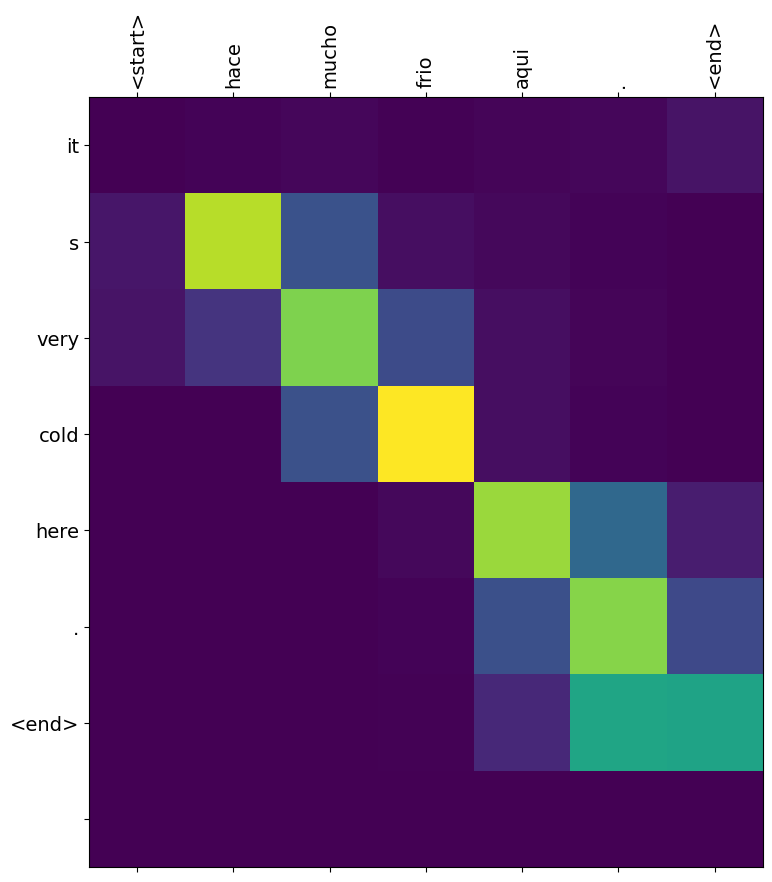

In [32]:
translate(u'hace mucho frio aqui.') # 유니코드로 u를 사용하는 문법인데 파이썬 3의 환경에서는 모든 문자열이 기본적으로 유니코드이므로 스페인어나 한글처럼 아스키 범위를 벗어나는 문자를 제대로 처리할 수 있어 무시하고 실행됨.

Input: <start> esta es mi vida . <end>
Predicted translation: this is my life . <end> 


/tmp/ipython-input-29-2919660472.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipython-input-29-2919660472.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


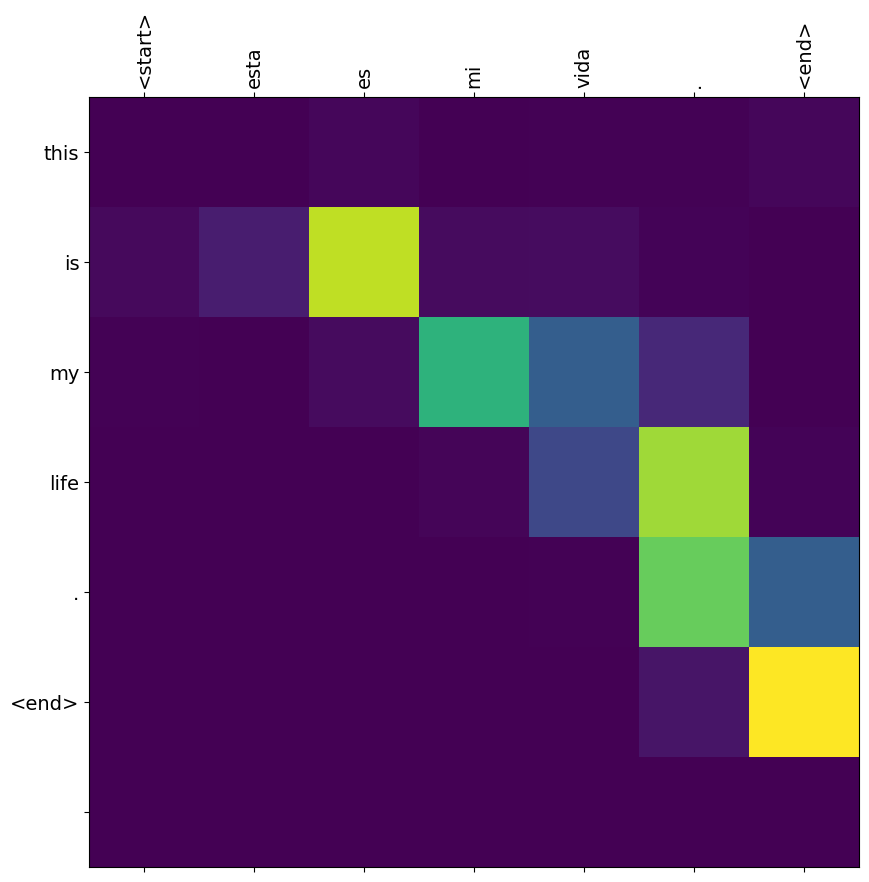

In [33]:
translate(u'esta es mi vida.')

Input: <start> ¿ todavia estan en casa ? <end>
Predicted translation: are you still home ? <end> 


/tmp/ipython-input-29-2919660472.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipython-input-29-2919660472.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


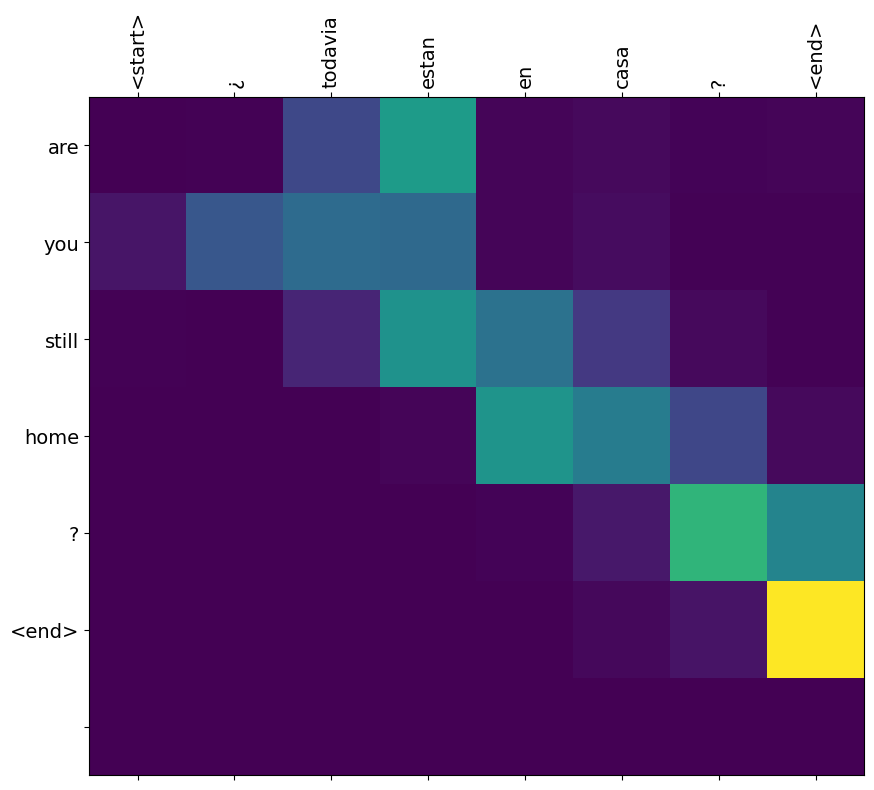

In [34]:
translate(u'¿todavia estan en casa?')

Input: <start> trata de averiguarlo . <end>
Predicted translation: try to figure it out . <end> 


/tmp/ipython-input-29-2919660472.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
/tmp/ipython-input-29-2919660472.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)


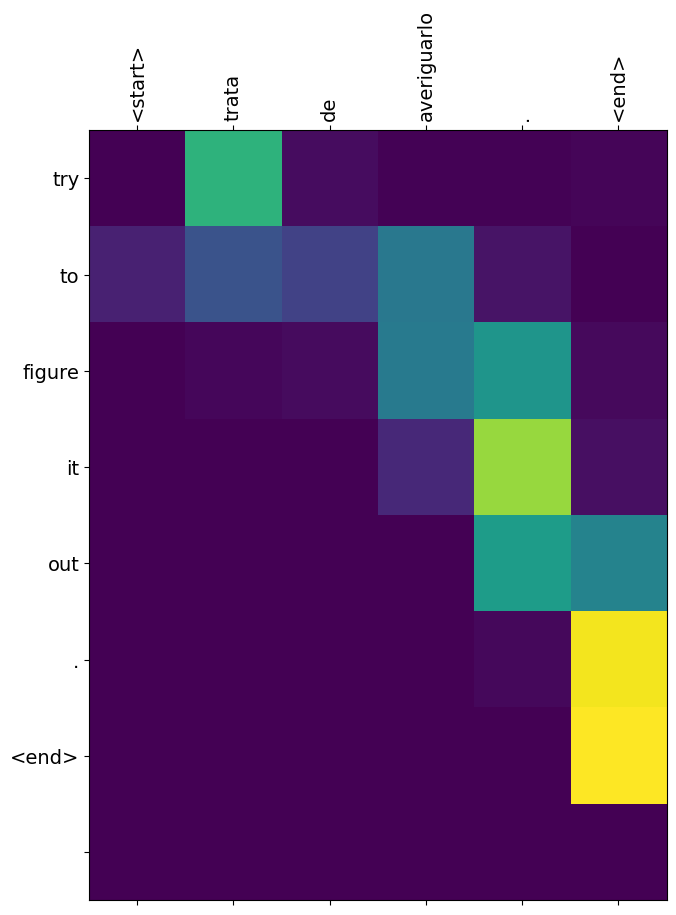

In [35]:
# 잘못된 번역
translate(u'trata de averiguarlo.')

## 다음 단계

* 앞서 영어-스페인어 데이터셋을 이용해 모델을 훈련하였습니다. 이제 영어-프랑스어, 영어-한국어 등의 [댜양한 다른 언어 데이터셋](http://www.manythings.org/anki/)을 활용하여 모델을 훈련시켜 봅시다
* 또한 이 예제에서는 데이터셋을 제한하여 모델을 만들어 보았습니다. 이제 더 많은 데이터셋 혹은 더 많은 에포크(epochs)를 적용하여 모델을 훈련해봅시다
